### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

### Load Datasets & Data Preprocessing

#### Description of features
- **WDIR**: Wind direction
- **WSPD**: Wind speed
- **rWSPD**: Lagged wind speed
- **rWSPD_T**: Transformed lagged wind speed
- **Fetch**: Fetch distance (*F*)
- **u**: Transformed wind speed
- **uSq**: $u^2$
- $Z_2 = u\sqrt{F}$
- $Z_3 = F$
- $Z_4 = \frac{F^{3/2}}{u}$

#### Description of target
- **SWHft**: Significant wave height (*H*)

In [2]:
wind_cols = ['u','uSq','Z2','Z3','Z4']

# Load datasets
df_buoy_04_13 = pd.read_csv('Data_Buoy_2004_2013.csv')
df_stn_04_13 = pd.read_csv('Data_Sikorsky_2004_2013.csv')
df_stn_73_04 = pd.read_csv('Data_Sikorsky_1973_2004.csv')

# Rename columns
df_buoy_04_13 = df_buoy_04_13.rename(columns={'SWHft':'H'})
df_stn_04_13 = df_stn_04_13.rename(columns={'Fetch':'Z3'})
df_stn_73_04 = df_stn_73_04.rename(columns={'Fetch':'Z3'})

# Add transformed wind speed (u)
df_stn_04_13['u'] = df_stn_04_13['rWSPD_T'].shift(-1).ffill()
df_stn_73_04['u'] = df_stn_73_04['rWSPD_T'].shift(-1).ffill()

# Add squared terms (u^2)
df_stn_04_13['uSq'] = df_stn_04_13['u']**2
df_stn_73_04['uSq'] = df_stn_73_04['u']**2

# Add interaction terms (Z2, Z4)
df_stn_04_13['Z2'] = np.sqrt(df_stn_04_13['Z3']) * df_stn_04_13['u']
df_stn_73_04['Z2'] = np.sqrt(df_stn_73_04['Z3']) * df_stn_73_04['u']
df_stn_04_13['Z4'] = (df_stn_04_13['Z3']**1.5) / df_stn_04_13['u']
df_stn_73_04['Z4'] = (df_stn_73_04['Z3']**1.5) / df_stn_73_04['u']

# Data aggregation
df1 = pd.concat([df_buoy_04_13[['TimeStamp_1','H']], df_stn_04_13[wind_cols]], axis=1)
df2 = df_stn_73_04[['TimeStamp_1'] + wind_cols].copy()

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

df1.head()

,H,u,uSq,Z2,Z3,Z4
TimeStamp_1,,,,,,
2004-11-01 00:00:00,3.249133,4.38474,19.225945,556.247086,16093.4,465615.964363
2004-11-01 01:00:00,3.249133,6.87748,47.299731,872.475497,16093.4,296853.635864
2004-11-01 02:00:00,1.960359,6.56483,43.096993,832.812792,16093.4,310991.288972
2004-11-01 03:00:00,2.001249,5.31423,28.241040,674.161969,16093.4,384177.000917
2004-11-01 04:00:00,3.254957,5.93953,35.278017,753.487381,16093.4,343731.733585


### Distribution of Features & Target

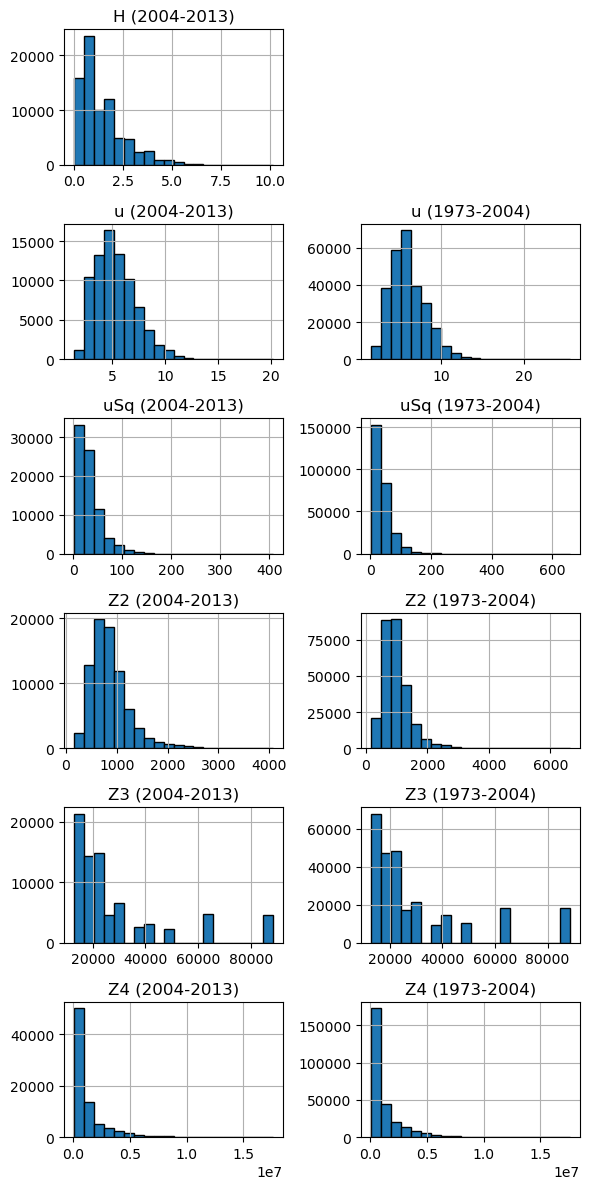

In [3]:
plt.figure(figsize=(6, 12))

# Numerical columns
num_cols = df1.columns

for i, col in enumerate(num_cols, start=1):
    # Left column: Histograms of df1 (2004-2013)
    plt.subplot(len(num_cols), 2, 2*i-1)
    df1[col].hist(bins=20, edgecolor='black')
    plt.title(f"{col} (2004-2013)")
    
    # Right column: Histograms of df2 (1973-2004)
    if i > 1:
        plt.subplot(len(num_cols), 2, 2*i)
        df2[col].hist(bins=20, edgecolor='black')
        plt.title(f"{col} (1973-2004)")

plt.tight_layout()
plt.show()

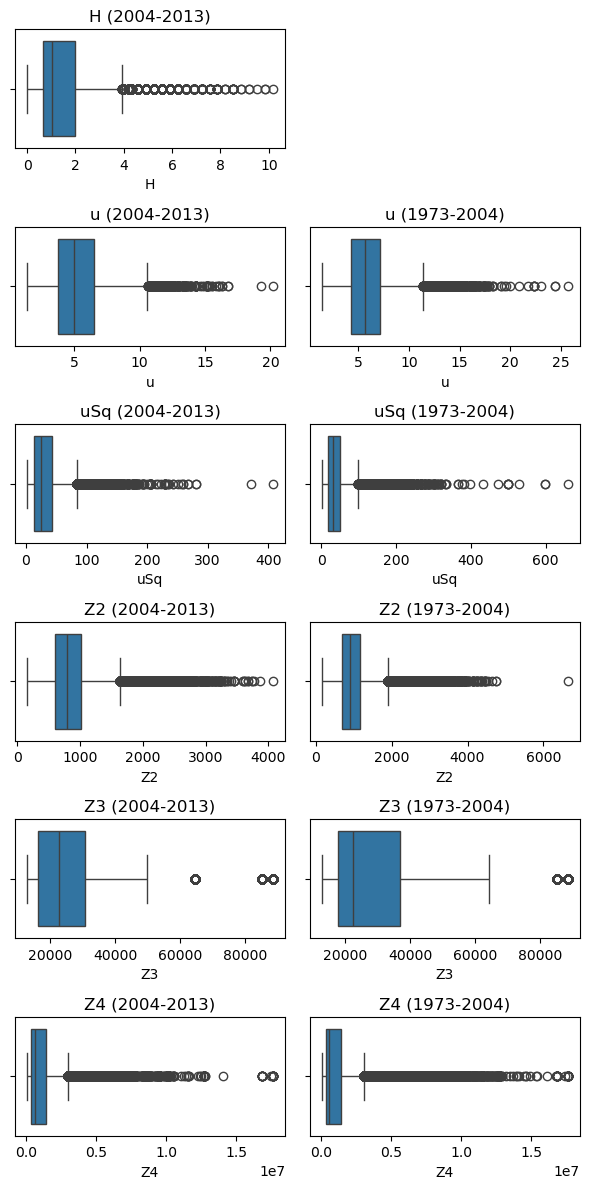

In [4]:
plt.figure(figsize=(6, 12))

# Numerical columns
num_cols = df1.columns

for i, col in enumerate(num_cols, start=1):
    # Left column: Box plots of df1 (2004-2013)
    plt.subplot(len(num_cols), 2, 2*i-1)
    sns.boxplot(data=df1, x=col)
    plt.title(f"{col} (2004-2013)")
    
    # Right column: Box plots of df2 (1973-2004)
    if i > 1:
        plt.subplot(len(num_cols), 2, 2*i)
        sns.boxplot(data=df2, x=col)
        plt.title(f"{col} (1973-2004)")

plt.tight_layout()
plt.show()

### Correlation Analysis

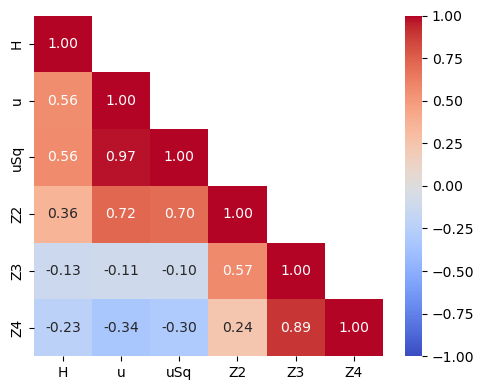

In [5]:
df_corr = df1.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, fmt='.2f', annot=True, 
            cmap='coolwarm', mask=np.triu(np.ones_like(df_corr), 1))

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov (KS) Test

- **Two-sample KS test**: To compare the distributions of a feature between the training set and the test set
- **Null hypothesis**: There is no significant difference between the distributions of two datasets.

#### Comparison of feature distributions between the training and test sets

In [6]:
# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Data normalization
scaler = MinMaxScaler()
df_train_T = scaler.fit_transform(df_train)
df_test_T = scaler.transform(df_test)
df_train_T = pd.DataFrame(df_train_T, columns=df1.columns)
df_test_T = pd.DataFrame(df_test_T, columns=df1.columns)

# KS test
results = []
for col in df1.columns:
    statistic, p_value = ks_2samp(df_train_T[col], df_test_T[col])
    results.append((col, statistic, p_value))

ks_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-value'])
ks_df

,Feature,KS Statistic,P-value
0,H,0.024161,0.000217
1,u,0.014083,0.089581
2,uSq,0.014083,0.089581
3,Z2,0.020694,0.002462
4,Z3,0.008849,0.570813
5,Z4,0.012247,0.190639


#### Comparison of feature distributions between the 2004-2013 and 1973-2004 datasets

In [7]:
# Drop columns
df1 = df1.drop(['H'], axis=1)

# Data normalization
scaler = MinMaxScaler()
df1_T = scaler.fit_transform(df1)
df2_T = scaler.transform(df2)
df1_T = pd.DataFrame(df1_T, columns=df1.columns)
df2_T = pd.DataFrame(df2_T, columns=df2.columns)

# KS test
results = []
for col in df1.columns:
    statistic, p_value = ks_2samp(df1_T[col], df2_T[col])
    results.append((col, statistic, p_value))

ks_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-value'])
ks_df

,Feature,KS Statistic,P-value
0,u,0.122588,0.000000e+00
1,uSq,0.122588,0.000000e+00
2,Z2,0.138416,0.000000e+00
3,Z3,0.042513,1.860662e-96
4,Z4,0.042748,1.601888e-97
